# AutoML Regression Modelling with PyCaret

In [47]:
"""
See the last cell for the runtime dependencies of this notebook.

Run these cells one by one the first time to understand how a CSV is generated for a single
circuit & crime type:
    1. the data is loaded from the csv
    2. the data is split on crimetypes
    3. the data is split on circuits
    4. many models are trained for a crimetype & circuit
    5. the best model is selected and tuned
    6. the best model is used to predict on all available data and RMSE noted
    7. offline predictions are made for variations of input variables 
    8. step circuit, crimes for next combination in the next block
    9. Finally all 9 CSV's from preceding step are combined into one all_predictions.csv
"""

RUNONCE=False

import pandas as pd
from pycaret.regression import *
%matplotlib inline

sen = pd.read_csv("./sentencing_post_eda.csv")

#segmentation of data by crime type i.e. statut code
dfs = [ sen[sen["statut"].str.startswith("893", na=False)], \
        sen[sen["statut"].str.startswith("812", na=False)], \
        sen[sen["statut"].str.startswith("322", na=False)] ]

In [48]:
circuits=["CIRCUIT 06 - CLEARWATER", "CIRCUIT 17 - FT. LAUDERDALE", "CIRCUIT 11 - MIAMI"]   #CIRCUIT 09 - ORLANDO
crimes=["trafficking/893", "robbery/812", "driving/322"]

#TODO: change up circuit & crime below to generate 3 crimes for every circuit. Totalling 9.

crime = 0
d = dfs[crime]
circuit = 0
d=d[d.circuit==circuits[circuit]]

In [49]:
print(f"total: {len(d)}")

total: 55611


In [50]:
#sen2[["age", "totpts", "sp_cj_total_days", "totpts_cut_group"]].describe().apply(lambda s: s.apply('{0:.2f}'.format))
#sen2[["age", "totpts", "sp_cj_total_days", "totpts_cut_group"]].hist()

In [51]:
#constrain to just the output & input variables
d = d[['sp_cj_total_days', 'gender', 'age', 'race', 'circuit', 'totpts_cut_group', 'clfely', 'totpts_cut_range']]

data = d.sample(frac=0.9, random_state=786)
data_unseen = d.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (50050, 8)
Unseen Data For Predictions: (5561, 8)


In [52]:
#Transform & Normalize variables
# !!!!!!!!!!!   There is a confirm step. Needs an "Enter" to carry on past this cell  !!!!!!!!!!!!

from pycaret.regression import *
X = setup(data = data, target = 'sp_cj_total_days', session_id=123, normalize = True, 
          transformation = True, #transform_target = True,
          ignore_features = ['totpts_cut_range']
          )

,Description,Value
0,session_id,123
1,Target,sp_cj_total_days
2,Original Data,"(50050, 8)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(35034, 29)"


In [53]:
best = compare_models(exclude = [])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,128.8533,96718.5872,309.0710,0.5754,3.0279,0.9443,0.0220
lightgbm,Light Gradient Boosting Machine,132.4459,96663.5388,309.0464,0.5748,3.0544,0.9034,0.9690
br,Bayesian Ridge,128.8935,97181.7357,309.8037,0.5733,3.0267,0.9431,0.0560
gbr,Gradient Boosting Regressor,133.2856,97134.4582,309.6884,0.5730,3.1364,0.9417,0.3590
lr,Linear Regression,129.2124,97443.1916,310.2528,0.5721,3.0284,0.9449,0.0240
lasso,Lasso Regression,131.5962,100928.3346,315.3701,0.5587,3.0610,0.9645,0.0550
par,Passive Aggressive Regressor,115.8579,103668.9573,319.8782,0.5457,2.3742,0.8438,0.1090
huber,Huber Regressor,118.3730,105475.1587,322.5171,0.5383,2.5091,0.8036,0.4610
xgboost,Extreme Gradient Boosting,134.4679,108146.8620,326.9544,0.5196,3.0450,0.9030,1.2810
knn,K Neighbors Regressor,141.0954,110596.0584,330.9022,0.5117,2.9532,0.9946,0.1630


In [54]:
tuned = tune_model(best)
final = finalize_model(tuned)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,122.9859,72444.1325,269.1545,0.6257,3.0635,1.1094
1,132.8837,102369.6337,319.9525,0.5704,3.0210,1.0827
2,130.0162,104087.4418,322.6259,0.5605,3.0422,0.8149
3,134.7378,123830.6873,351.8958,0.5559,3.0356,0.7001
4,131.3701,102532.1216,320.2064,0.5404,3.0532,1.0462
5,136.0475,125404.5507,354.1250,0.5320,3.0285,0.8062
6,126.3354,86802.1580,294.6221,0.5942,3.0082,1.1549
7,127.8455,111902.1304,334.5178,0.5791,3.0378,0.7913
8,126.0250,76161.8250,275.9743,0.5900,3.0267,1.1116
9,123.2123,58033.8939,240.9022,0.6273,3.0447,0.9083


In [55]:
print(tuned)

Ridge(alpha=7.73, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)


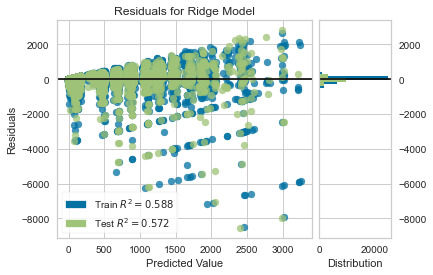

In [56]:
plot_model(tuned)

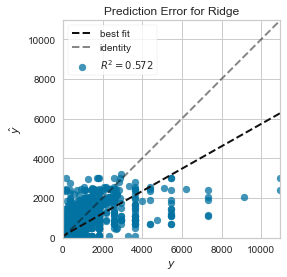

In [57]:
plot_model(tuned, plot = 'error')

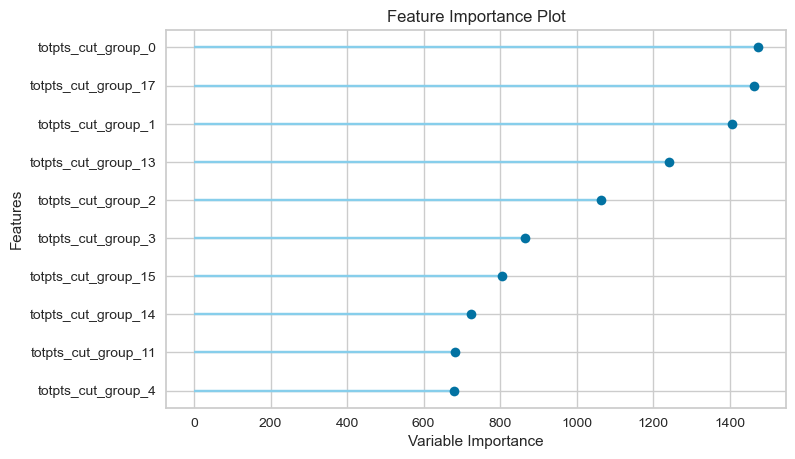

In [58]:
plot_model(tuned, plot='feature')

In [59]:
predict_model(tuned);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,126.6494,93708.6599,306.1187,0.5723,3.0359,1.0028


In [60]:
print(final)

Ridge(alpha=7.73, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)


In [61]:
predict_model(final);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,126.3435,93025.6240,305.0010,0.5755,3.0298,1.0015


In [62]:
unseen_predictions = predict_model(final, data=data_unseen)
from pycaret.utils import check_metric
rmse = check_metric(unseen_predictions.sp_cj_total_days, unseen_predictions.Label, 'RMSE')
#save_model(final,'Circuit06-893-ridge')

In [63]:
check_metric(unseen_predictions[unseen_predictions.race=="BLACK"].sp_cj_total_days, unseen_predictions[unseen_predictions.race=="BLACK"].Label, 'R2')

0.5735

In [64]:
check_metric(unseen_predictions[unseen_predictions.race=="WHITE"].sp_cj_total_days, unseen_predictions[unseen_predictions.race=="WHITE"].Label, 'R2')

0.5482

<AxesSubplot:>

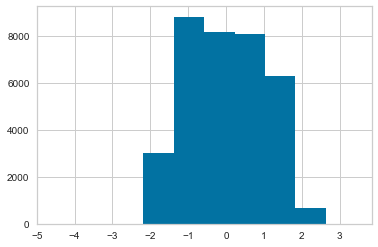

In [65]:
#get_config('X_train').shape
#get_config('X_test').dtypes
#Confirm that ages were normalized
get_config('X_train').age.hist()

In [66]:
preds = None

if (not RUNONCE):
    RUNONCE = True
    
    zipped_lists = zip(data_unseen.totpts_cut_range.unique(), data_unseen.totpts_cut_group.unique())
    sorted_pairs = sorted(zipped_lists)

    tuples = zip(*sorted_pairs)
    list1, list2 = [ list(tuple) for tuple in  tuples]
    k={v:i for i,v in enumerate(list2)}

    """
    TODO: This block takes a while to run but only needs to be run once and after that convert to a raw block
    The preds variable can be reused for the 8 other runs
    """

    r = pd.Series(0, index=data_unseen.columns)
    preds = pd.DataFrame(columns=data_unseen.columns)

    for age in range(20,86):
        for gender in ("MALE","FEMALE"):
            for race in ["BLACK", "WHITE"]:
                for ptsgrp in range(0,18):
                    for fly in ["1ST DEGREE", "1ST/LIFE", "2ND DEGREE", "3RD DEGREE", "LIFE"]:
                        row=r.copy()
                        row[list(data_unseen.columns)] = \
                            [0, gender, age, race, "",ptsgrp,fly,list1[k[ptsgrp]]]
                        preds = preds.append(row, ignore_index=True)
                    
len(preds)

23760

In [67]:
final = predict_model(final, data=preds.copy(deep=True))
final.rename(columns = {'Label':'predicted_sentence_days'}, inplace = True)
final["error_margin_days"]=rmse
final["crime"]=crimes[crime]    
final["circuit"]=circuits[circuit]
final.to_csv(f"./{circuits[circuit]}_{crimes[crime].split('/')[1]}.csv",index=False)

In [68]:
final

,sp_cj_total_days,gender,age,race,circuit,totpts_cut_group,clfely,totpts_cut_range,predicted_sentence_days,error_margin_days,crime
0,0,MALE,20,BLACK,CIRCUIT 06 - CLEARWATER,0,1ST DEGREE,"(0.0, 22.0]",286.597290,303.8533,trafficking/893
1,0,MALE,20,BLACK,CIRCUIT 06 - CLEARWATER,0,1ST/LIFE,"(0.0, 22.0]",340.638550,303.8533,trafficking/893
2,0,MALE,20,BLACK,CIRCUIT 06 - CLEARWATER,0,2ND DEGREE,"(0.0, 22.0]",79.153564,303.8533,trafficking/893
3,0,MALE,20,BLACK,CIRCUIT 06 - CLEARWATER,0,3RD DEGREE,"(0.0, 22.0]",39.879150,303.8533,trafficking/893
4,0,MALE,20,BLACK,CIRCUIT 06 - CLEARWATER,0,LIFE,"(0.0, 22.0]",455.038940,303.8533,trafficking/893
...,...,...,...,...,...,...,...,...,...,...,...
23755,0,FEMALE,85,WHITE,CIRCUIT 06 - CLEARWATER,17,1ST DEGREE,"(194.0, 204.0]",3212.540039,303.8533,trafficking/893
23756,0,FEMALE,85,WHITE,CIRCUIT 06 - CLEARWATER,17,1ST/LIFE,"(194.0, 204.0]",3266.581055,303.8533,trafficking/893
23757,0,FEMALE,85,WHITE,CIRCUIT 06 - CLEARWATER,17,2ND DEGREE,"(194.0, 204.0]",3005.096191,303.8533,trafficking/893
23758,0,FEMALE,85,WHITE,CIRCUIT 06 - CLEARWATER,17,3RD DEGREE,"(194.0, 204.0]",2965.821777,303.8533,trafficking/893


In [69]:
pip list

Package                            Version
---------------------------------- -------------------
absl-py                            0.11.0
affinegap                          1.12
aif360                             0.4.0
alabaster                          0.7.12
alembic                            1.7.5
altair                             4.1.0
anaconda-client                    1.7.2
anaconda-navigator                 2.1.1
anaconda-project                   0.9.1
appdirs                            1.4.4
applaunchservices                  0.2.1
appnope                            0.1.2
appscript                          1.1.2
argcomplete                        1.12.2
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astor                              0.8.1
astroid                            2.5
astropy                            4.2
async-generator                    1.10
atomicwrites                       1.4.0
a